## Prepare data in Colab enviornment

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir data
! mkdir data/tid2013
! cp -r drive/MyDrive/Colab\ Notebooks/img-quality-assesment/data/tid2013/distorted_images ./data/tid2013/
! cp drive/MyDrive/Colab\ Notebooks/img-quality-assesment/data/tid2013/mos_with_names.txt ./data/tid2013/
! cp -r drive/MyDrive/Colab\ Notebooks/img-quality-assesment/nima .

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘data/tid2013’: File exists


#### Install libraries

In [1]:
! pip install livelossplot

In [6]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow.keras as keras

# Start : In local docker only
import sys
sys.path.append('/home/jovyan/work') 
sys.path.append('..')
# End : In local docker only

import nima as nima

### Load Dataset

In [7]:
from nima.utils.tid_dataset_utils import load_tid_data
from nima.config import DATASET_DIR
from nima.utils.ava_downloader import print_msg

p_dataset_dir = DATASET_DIR
p_model_name = 'vgg'
p_batch_size = 64
p_epochs = 1
p_sample_size=1000
p_metrics = ['accuracy']
p_verbose = 1
p_freeze_base = True

tid_dataset_dir = os.path.join(p_dataset_dir, 'tid2013')
tid_images_dir = os.path.join(tid_dataset_dir, 'distorted_images')
img_format = 'bmp'
print_msg(f'Images directory {tid_images_dir}')

# Load the dataset
x_col, y_cols = 'image_id', 'rating'
df_train, df_valid, df_test = load_tid_data(tid_dataset_dir, p_sample_size)
assert len(df_train) > 0 and len(df_valid) > 0 and len(df_test) > 0, 'Empty dataframe'
train_batch_size = valid_batch_size = p_batch_size
test_batch_size = min(p_batch_size, 32, len(df_test))

df_train.head()

Images directory C:\Users\amaindola\Google Drive\Colab Notebooks\img-quality-assesment\data\tid2013\distorted_images
	Number of samples picked 1000


,rating,image_id
0,2.27027,i11_10_5
1,3.85714,i24_19_5
2,4.00000,i19_05_4
3,5.56410,i03_18_3
4,3.34286,i25_19_5


In [8]:
df_train.describe()

,rating
count,720.000000
mean,4.465209
std,1.235285
min,0.476190
25%,3.556615
50%,4.564275
75%,5.516670
max,6.815790


### Create the model

In [9]:
from nima.model.model_builder import NIMA
from nima.config import INPUT_SHAPE, CROP_SHAPE
from tensorflow.keras.losses import mean_squared_error

# Form the NIMA Aesthetic Model
nima_technical_cnn = NIMA(base_model_name=p_model_name, model_type='technical',
                            input_shape=INPUT_SHAPE, metrics=p_metrics)

# Build the model for training
nima_technical_cnn.build()
nima_technical_cnn.compile()
nima_technical_cnn.model.summary()

	NIMA Base CNN module - tensorflow.keras.applications.vgg19.VGG19
80142336/80134624 [==============================] - 16s 0us/step
	Freezing base CNN layers.
	Model compiled successfully.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
bloc

### Create Model

In [10]:
from nima.model.data_generator import TrainDataGenerator

# Get the generator
train_generator = TrainDataGenerator(df_train, tid_images_dir, x_col=x_col, y_col=y_cols,
                                     img_format=img_format, num_classes=1,
                                     preprocess_input=nima_technical_cnn.get_preprocess_function(),
                                     batch_size=train_batch_size, input_size=INPUT_SHAPE, crop_size=CROP_SHAPE)
valid_generator = TrainDataGenerator(df_valid, tid_images_dir, x_col, y_cols, img_format=img_format, num_classes=1,
                                     preprocess_input=nima_technical_cnn.get_preprocess_function(),
                                     batch_size=train_batch_size, input_size=INPUT_SHAPE, crop_size=CROP_SHAPE)

	Found 720 valid image filenames belonging to 1 classes.
	Found 180 valid image filenames belonging to 1 classes.


##### Train the model

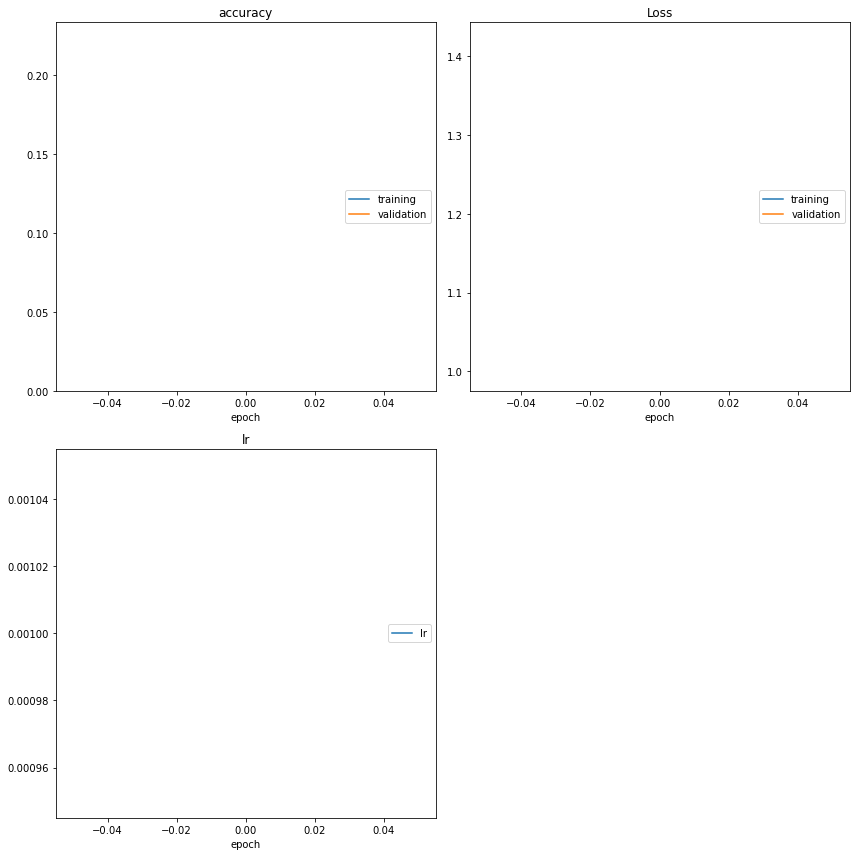

	Training Time (HH:MM:SS) : 00:04:33


In [11]:
train_result_df, train_weights_file = nima_technical_cnn.train_model(train_generator, valid_generator,
                                                                     epochs=p_epochs, verbose=p_verbose)

In [17]:
# df_test['image_id'] = df_test['image_id'] + '.bmp'
df_test

,rating,image_id
0,5.24242,i09_08_2.bmp
1,3.16667,i21_03_3.bmp
2,3.96875,i09_11_3.bmp
3,5.36585,i18_20_3.bmp
4,5.27778,i12_20_2.bmp
...,...,...
95,4.64286,i13_07_3.bmp
96,4.33333,i01_20_5.bmp
97,2.70270,i22_03_5.bmp
98,3.48571,i02_06_4.bmp


#### Test the model

In [18]:
# from nima.model.data_generator import TestDataGenerator

# # Get the generator
# test_generator = TestDataGenerator(df_test, tid_images_dir, x_col=x_col, y_col=None,
#                                    img_format=img_format, num_classes=1,
#                                    preprocess_input=nima_technical_cnn.get_preprocess_function(),
#                                    batch_size=test_batch_size, input_size=INPUT_SHAPE)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_steps = np.ceil(len(test_generator) / test_batch_size)

# # print_msg(f'Testing Batch size:{test_batch_size}, steps:{test_steps}', 1)


test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_dataframe(
    df_test,
    directory=tid_images_dir,
    x_col="image_id",
    y_col=None,
    batch_size=test_batch_size,
    class_mode=None,
    target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
    preprocessing_function=nima_technical_cnn.get_preprocess_function()
)

predictions = nima_technical_cnn.model.predict(test_generator, steps=test_steps)
df_test['rating_predict'] = predictions

df_test

Found 100 validated image filenames.


Exception in thread Thread-9:
Traceback (most recent call last):
  File "C:\Users\amaindola\Anaconda3\envs\img-quality-assesment\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\amaindola\Anaconda3\envs\img-quality-assesment\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\amaindola\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\utils\data_utils.py", line 726, in _run
    with closing(self.executor_fn(_SHARED_SEQUENCES)) as executor:
  File "C:\Users\amaindola\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\utils\data_utils.py", line 703, in pool_fn
    pool = get_pool_class(True)(
  File "C:\Users\amaindola\Anaconda3\envs\img-quality-assesment\lib\multiprocessing\context.py", line 119, in Pool
    return Pool(processes, initializer, initargs, maxtasksperchild,
  File "C:\Users\amaindola\Anaconda3\envs\img-quality-assesment\lib\multiprocessing\pool.py", line 21

#### Test the model for one image

<class 'PIL.BmpImagePlugin.BmpImageFile'>


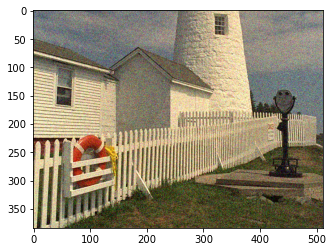

In [33]:
from nima.utils import image_utils
import matplotlib.pyplot as plt

image = df_test.iloc[0]['image_id']
y_true = df_test.iloc[0]['rating']

# Form image path
image_path = os.path.join(tid_images_dir, f'{image}.bmp')
# convert to numpy array
x = image_utils.load_img(image_path, INPUT_SHAPE)
print(type(x))
plt.imshow(x)

In [20]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

image = df_test.iloc[0]['image_id']
image_path = os.path.join(tid_images_dir, f'{image}.bmp')
target_size = INPUT_SHAPE

x = load_img(image_path, target_size=(target_size[0], target_size[1]))  # load the image in pillow format
x = img_to_array(x)  # convert to numpy array
x = x.reshape(1, *x.shape)
x = nima_technical_cnn.preprocess_input(x)
predict = nima_technical_cnn.model.predict(x)
predict

array([[nan]], dtype=float32)

array([[0.]], dtype=float32)